This Notebooks shows how to load a `seillra` model and use it to caluclate chromatin features.
It also shows how to access chromatin feature annotation, and how to calculate sequence classes.

**STEP 1:** 

Import `seillra` and other packages:

In [1]:
import os, sys
import pandas as pd
import torch
import numpy as np
import collections

import seillra as sl

**STEP 2:**

- Decide on rank of approximate linear layers: 64
- Decide on the output type: chromatin profiles 
    - `projection = False` d=231,907 chromatin features 
    - `projection = True` d=61 sequence classes of which typically only the first 40 are used
- Decide on the device to use for inference (CPU)
- If infierence is on arm64 hardware (e.g. macbook), use `qnnpack` as backend if `quant == "CPU"`

Then load the according model.

In [2]:
import platform

# - what model to load
rank = 64
sequence_classes = False  # True
sequence_type = "sequence"  # "variant"
quant = "CPU"  # None, "GPU_fp16", "GPU_int8"
projection = False  # True; Fasle will give 21,907 chromatin features


# - CPU quantization backend
if quant == "CPU":
    if platform.machine() == "arm64":
        if "qnnpack" in torch.backends.quantized.supported_engines:
            torch.backends.quantized.engine = "qnnpack"
        else:
            raise RuntimeError("QNNPACK not supported on this arm64 machine.")
    if platform.machine() == "x86_64":
        if "fbgemm" in torch.backends.quantized.supported_engines:
            torch.backends.quantized.engine = "fbgemm"
        else:
            raise RuntimeError("FBGEMM not supported on this x86_64 machine.")
    print("Using quantized engine:", torch.backends.quantized.engine)

# - load the model
model = sl.Sei_LLRA(k=rank, projection=False, mode=sequence_type, quant=quant)

Using quantized engine: fbgemm


2026-01-21 11:27:07,464 - INFO - Checksum verified for url_a6038b62128b5b01_wts: 28a1a49ca62e4d67a62c170df3751f7255db6eea3923455c119c762dde446308
2026-01-21 11:27:07,464 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_a6038b62128b5b01_wts
2026-01-21 11:27:07,800 - INFO - Model weights loaded and set to eval mode.
2026-01-21 11:27:08,029 - INFO - Checksum verified for url_b9a0eb4608886e0d_wts: e50fe852023657a60952698c591b291df0e4db3111a0e8ea122546f70eee27c3
2026-01-21 11:27:08,030 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_b9a0eb4608886e0d_wts
2026-01-21 11:27:08,127 - INFO - Model weights loaded and set to eval mode.


(See the readme file for loading the Sei model components (trunk, head, projection) seperately)

**STEP 3:**

Use the model to predict sequence classes (since we indlucded the projection model for DNA input sequences):

- Generate 16 random input sequences
- Apply the `seillra` model
- Print (part of) the result

In [3]:
# - random 1-hot sequences
sequences = torch.randint(0, 4, (16, 4096))
x = torch.nn.functional.one_hot(sequences, num_classes=4).permute(0, 2, 1).float()

# - run the model
out = model(x.to("cpu"))

# - typically discard the "unintersting" sequence classes (see the original Sei repository/paper)
res = out[:, :22]

# - Sequence class scores for the first 3 sequences and first 11 classes
print(res[:3, :11])

tensor([[1.5424e-04, 9.7630e-04, 3.3923e-04, 4.0935e-04, 4.3136e-04, 2.3352e-03,
         4.5710e-03, 1.1464e-04, 1.0129e-04, 5.9831e-05, 2.6549e-04],
        [3.8044e-04, 2.2497e-03, 1.6247e-03, 1.7032e-03, 1.9628e-03, 1.2050e-02,
         1.8739e-02, 1.4412e-03, 1.2395e-03, 4.2817e-04, 2.6322e-03],
        [7.6110e-04, 1.3822e-03, 7.5301e-04, 3.0762e-04, 3.0624e-04, 1.4168e-03,
         3.4562e-03, 6.7248e-05, 9.1065e-05, 1.2290e-04, 9.0885e-05]])


**STEP 4:**

Plot a heatmap with sequence class annotations.

In [4]:
model.projection

False

Target annotations: (21907, 3):

                         context  assay     info
0         HeLa_Epithelium_Cervix  BTAF1     ID:1
1  H9_Embryonic_Stem_Cell_Embryo  EOMES  ID:1006
2  H9_Embryonic_Stem_Cell_Embryo  EP300  ID:1007
3  H9_Embryonic_Stem_Cell_Embryo  FOXH1  ID:1010
4  H9_Embryonic_Stem_Cell_Embryo  FOXH1  ID:1011
5  H9_Embryonic_Stem_Cell_Embryo  FOXP1  ID:1012
6  H9_Embryonic_Stem_Cell_Embryo  FOXP1  ID:1013


Text(0.5, 1.0, 'Heatmap for 16 sequences and first 22 chromatin features')

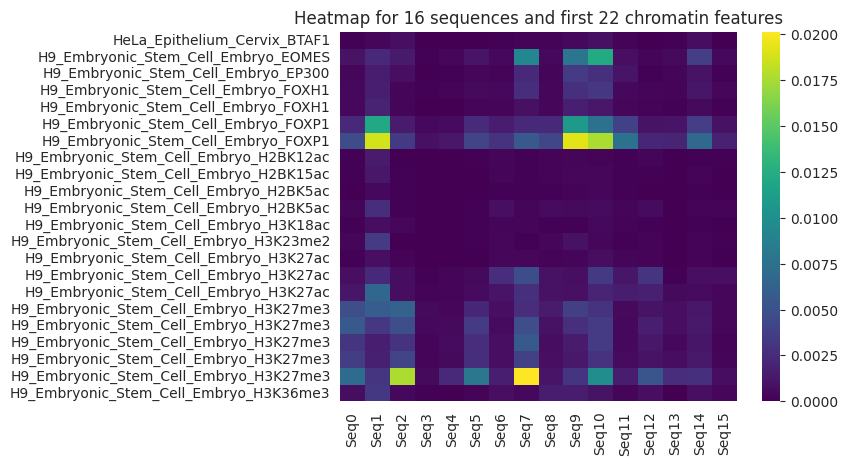

In [5]:
import pandas as pd

tgts = pd.DataFrame(model.head.target_annot)
print(f"Target annotations: {tgts.shape}:\n")
print(tgts.head(7))

# - make a heatmap of res for the first 55 seqs and 100 chromatin features
# - use sequences on the y-axis (and label accordingly)
# - use chromatin features on the x-axis (and label accordingly)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.heatmap(
    res.cpu().detach().numpy().T,
    yticklabels=tgts["context"][:22] + "_" + tgts["assay"][:22],
    xticklabels=[f"Seq{i}" for i in range(16)],
    cmap="viridis",
    vmin=0,
    vmax=res[:16, :22].max().item(),
)
plt.title("Heatmap for 16 sequences and first 22 chromatin features", fontsize=12)

**STEP 5:**

Project the chromatin profiles onto sequence classes. 
Keep only the first 40 ("meaningful") classes

In [6]:
projmod = sl.get_sei_projection(quant="CPU")
seq_classes = projmod(out)  # - re-use out from above
cls = seq_classes[:, :40]
print("\nSequence class scores for the first 7 sequences and first 11 classes:")
print(cls[:7, :11])

2026-01-21 11:27:11,011 - INFO - Checksum verified for url_f6f3b1c27e97399e_wts: ba3e530e53694c66a9573c0a38e0915986b95f19b99a962f357997eadaa33d44
2026-01-21 11:27:11,011 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_f6f3b1c27e97399e_wts
2026-01-21 11:27:11,016 - INFO - Model weights loaded and set to eval mode.



Sequence class scores for the first 7 sequences and first 11 classes:
tensor([[0.1964, 0.3929, 0.1966, 0.1965, 0.1966, 0.3931, 0.3930, 0.3931, 0.1965,
         0.5896, 0.1968],
        [0.5893, 0.3929, 0.1966, 0.1965, 0.1966, 0.3931, 0.5895, 0.3931, 0.3930,
         0.9826, 0.1968],
        [0.7858, 1.1788, 0.3931, 0.5896, 0.5899, 1.3758, 1.9651, 1.3759, 0.5895,
         2.5549, 0.9840],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1964, 0.3929, 0.1966, 0.1965, 0.1966, 0.3931, 0.5895, 0.3931, 0.1965,
         0.7861, 0.1968],
        [0.1964, 0.3929, 0.1966, 0.1965, 0.1966, 0.3931, 0.5895, 0.3931, 0.1965,
         0.9826, 0.1968],
        [0.1964, 0.1965, 0.1966, 0.1965, 0.0000, 0.3931, 0.3930, 0.1966, 0.1965,
         0.7861, 0.1968]])


Next, make a heatmap again, with sequence class annotation.

Text(0.5, 1.0, 'Heatmap for 16 sequences and first 40 sequence classes')

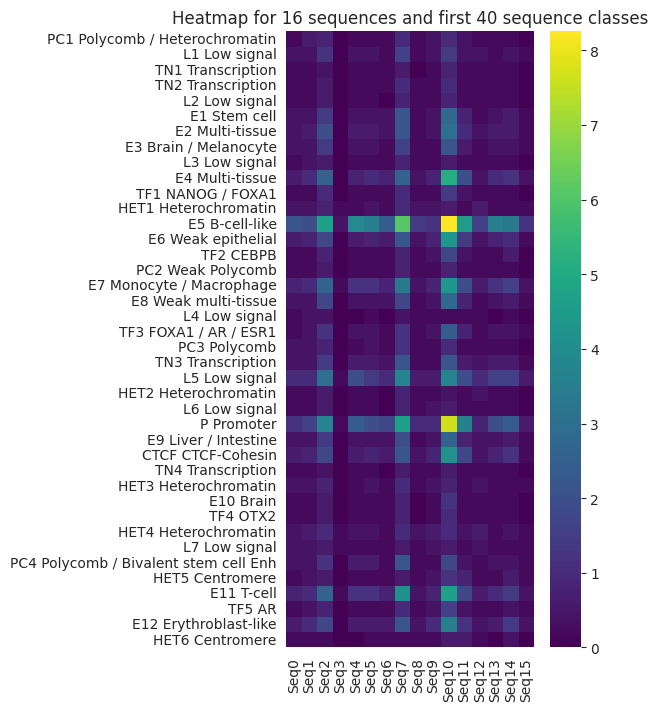

In [7]:
# - heatmap of the sequence classes
plt.figure(figsize=(4, 8))
sns.heatmap(
    cls.cpu().detach().numpy().T,
    # yticklabels=[f"Class{i}" for i in range(40)],
    yticklabels=projmod.class_annot,
    xticklabels=[f"Seq{i}" for i in range(16)],
    cmap="viridis",
    vmin=0,
    vmax=cls[:16, :40].max().item(),
)
plt.title("Heatmap for 16 sequences and first 40 sequence classes", fontsize=12)